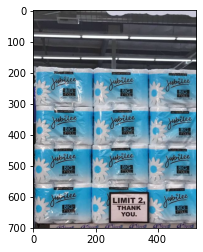

In [14]:
import cv2 
from ultralytics import YOLO 
from matplotlib import pyplot as plt
import numpy as np 
from PIL import Image
from time import sleep

model = YOLO("/home/pinole/ros2_ws/src/srv_vision/srv_vision/models/ultralytics_yolov8_model.pt")


image = cv2.imread("test_image_01.png")
plt.imshow(image)
plt.show()


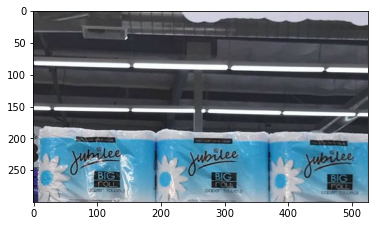

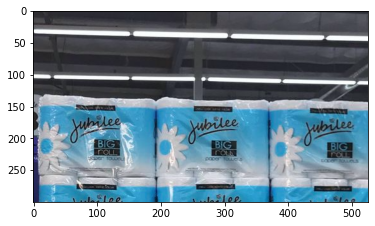

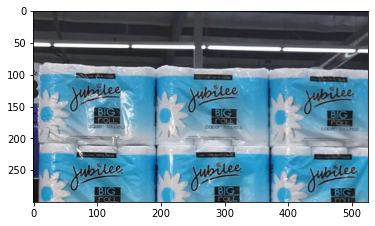

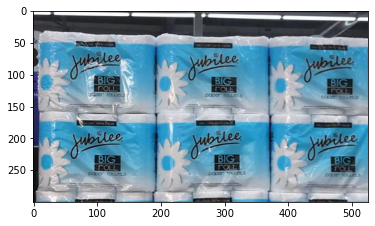

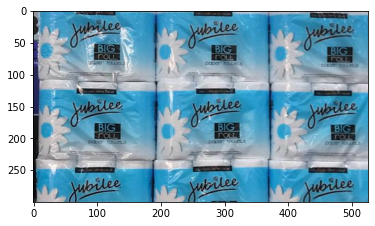

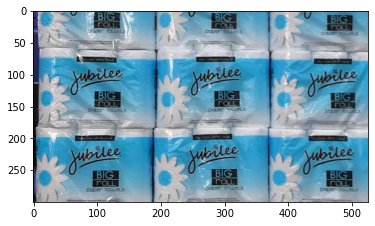

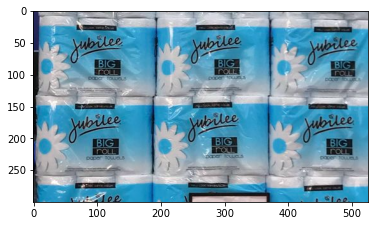

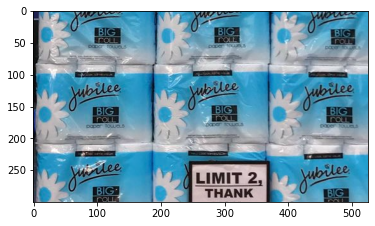

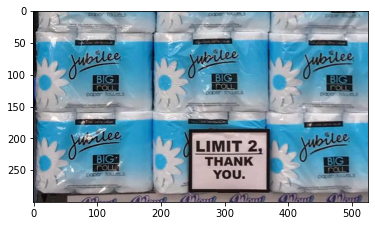

In [26]:
images = [] 
for r in range(0, image.shape[0]-300, 50):
    im_t = image[r:r+300]
    images.append(im_t)
    plt.imshow(im_t)
    plt.show()   

In [27]:
print(f"shape: {image.shape}")
print(f"testing roi: (300, 526, 3)")
print(f"total images: {len(images)}")

shape: (701, 526, 3)
testing roi: (300, 526, 3)
total images: 9


In [37]:
predictions = []
for i, img in enumerate(images): 
    print(f"img: {i}")
    counter = 0
    detections = []
    results = model.predict(img, verbose=False)
    results = results[0]
    try:
        results = results.boxes.cpu() 
        results = results.xyxy.numpy()
        for box in results:
            x_1, y_1, x_2, y_2 = box
            x_1, y_1, x_2, y_2 = int(x_1), int(y_1)+(50*i), int(x_2), int(y_2)+(50*i)
            c_x = (x_1 + x_2) // 2
            c_y = (y_1 + y_2) // 2
            predictions.append(((c_x, c_y), (x_1, y_1, x_2, y_2)))
            counter += 1
    except:
        pass
    print(f"Detected {counter} objects.")

# predictions

img: 0
Detected 3 objects.
img: 1
Detected 6 objects.
img: 2
Detected 6 objects.
img: 3
Detected 6 objects.
img: 4
Detected 9 objects.
img: 5
Detected 9 objects.
img: 6
Detected 9 objects.
img: 7
Detected 8 objects.
img: 8
Detected 7 objects.


In [76]:
centroids = []
boxes_c = []


for predict in predictions:
    index = -1
    
    centroid, boxes = predict
    c_1, c_2 = centroid
    
    for i, key in enumerate(boxes_c):
        dx_1, dy_1, dx_2, dy_2 = key
        if c_1 >= dx_1 and c_1 <= dx_2 and c_2 >= dy_1 and c_2 <= dy_2:
            index = i
            break
    
    if index == -1:
        centroids.append([])
        boxes_c.append((0, 0, 0, 0))
        index = len(centroids) -1
        
    centroids[index].append(centroid)
    boxes_c[index] = boxes
        
        
print(len(centroids))

17


In [77]:
centroids

[[(289, 241), (290, 245), (290, 247), (290, 247), (287, 255), (289, 279)],
 [(104, 240), (108, 247), (108, 246), (106, 248), (105, 256), (104, 281)],
 [(456, 244), (456, 253), (456, 254), (457, 254), (456, 259), (457, 284)],
 [(458, 334)],
 [(104, 332)],
 [(285, 334)],
 [(458, 360), (459, 373), (458, 372), (458, 372), (458, 371), (459, 386)],
 [(108, 358),
  (110, 375),
  (110, 375),
  (109, 374),
  (109, 374),
  (108, 392),
  (108, 417)],
 [(292, 360),
  (294, 378),
  (293, 377),
  (292, 376),
  (293, 375),
  (291, 391),
  (286, 417)],
 [(452, 471), (454, 496), (454, 499), (455, 498), (454, 498)],
 [(99, 469), (100, 494), (101, 497), (100, 497), (100, 497)],
 [(280, 470), (283, 496), (283, 499), (283, 497), (283, 496)],
 [(97, 581)],
 [(450, 582)],
 [(275, 581)],
 [(100, 608), (101, 626)],
 [(451, 608), (452, 624)]]

In [52]:
class KalmanFilter:
    def __init__(self, A, B, H, Q, R, P, x):
        self.A = A  # State transition matrix
        self.B = B  # Control input matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.P = P  # Estimate error covariance
        self.x = x  # State estimate
        
    def predict(self, u=0):
        self.x = np.dot(self.A, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        
    def update(self, z):
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        y = z - np.dot(self.H, self.x)
        self.x = self.x + np.dot(K, y)
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)
        return self.x

# Parámetros de inicialización del filtro de Kalman
dt = 1.0  # Intervalo de tiempo
A = np.array([[1, dt], [0, 1]])  # Matriz de transición de estado
B = np.array([[0.5 * dt**2], [dt]])  # Matriz de entrada de control
H = np.array([[1, 0]])  # Matriz de observación
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Covarianza del ruido del proceso
R = np.array([[1]])  # Covarianza del ruido de la medición
P = np.array([[1, 0], [0, 1]])  # Covarianza del error de estimación
x = np.array([[0], [0]])  # Estimación inicial del estado

In [50]:
true_values = []

results = model.predict(image, verbose=False)
results = results[0]
results = results.boxes.cpu()
results = results.xyxy.numpy() 
for box in results: 
    x_1, y_1, x_2, y_2 = box
    x_1, y_1, x_2, y_2 = int(x_1), int(y_1), int(x_2), int(y_2)
    c_x = (x_1 + x_2) // 2
    c_y = (y_1 + y_2) // 2
    true_values.append((c_x, c_y))

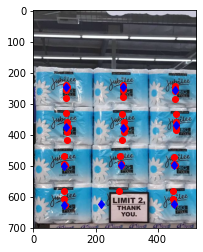

In [51]:
plt.imshow(image)
for c in centroids:
    for c_x, c_y in c:
        plt.plot(c_x, c_y, 'ro')
        
for c_x, c_y in true_values:
        plt.plot(c_x, c_y, 'bd')
plt.show()

In [69]:
estimated_position = []
for i, c in enumerate(centroids): 
    kf = KalmanFilter(A, B, H, Q, R, P, x)
    print(f"Centroid {i} prediction: ")
    c_np = np.array(c)    
    cx_np = np.mean(c_np[:, 0])
    cy_np = np.mean(c_np[:, 1])
    print(f"mean -> x: {int(cx_np)}, y: {int(cy_np)}")
    for c_x, c_y in c:
        kf.predict()
        estimated_position = kf.update(np.array([[c_y]]))
        print(f"x: {int(estimated_position[0][0])}, y: {int(estimated_position[1][0])}")
        
        
        

Centroid 0 prediction: 
mean -> x: 289, y: 252
x: 160, y: 80
x: 243, y: 81
x: 276, y: 62
x: 286, y: 45
x: 293, y: 34
x: 305, y: 29

Centroid 1 prediction: 
mean -> x: 105, y: 253
x: 160, y: 79
x: 244, y: 82
x: 276, y: 62
x: 287, y: 45
x: 294, y: 35
x: 307, y: 30

Centroid 2 prediction: 
mean -> x: 456, y: 258
x: 162, y: 81
x: 250, y: 84
x: 284, y: 64
x: 295, y: 47
x: 300, y: 35
x: 312, y: 30

Centroid 3 prediction: 
mean -> x: 458, y: 334
x: 222, y: 111

Centroid 4 prediction: 
mean -> x: 104, y: 332
x: 221, y: 110

Centroid 5 prediction: 
mean -> x: 285, y: 334
x: 222, y: 111

Centroid 6 prediction: 
mean -> x: 458, y: 372
x: 240, y: 119
x: 368, y: 124
x: 417, y: 94
x: 432, y: 68
x: 435, y: 51
x: 441, y: 40

Centroid 7 prediction: 
mean -> x: 108, y: 380
x: 238, y: 119
x: 369, y: 124
x: 419, y: 95
x: 435, y: 69
x: 438, y: 51
x: 445, y: 41
x: 458, y: 35

Centroid 8 prediction: 
mean -> x: 291, y: 382
x: 240, y: 119
x: 372, y: 125
x: 422, y: 95
x: 438, y: 69
x: 440, y: 51
x: 446, y: 41


In [113]:
class KalmanFilterPro:
    x_prev = 0.0
    p_prev = 0.5
    k = 0.9
    
    def __init__(self, x0 = 0.0):
        self.x_prev = x0
        self.x_prev = 0.0
    
    def update(self, z):
        r = np.var([self.x_prev] + [z]) 
        x = self.x_prev + self.k * (z - self.x_prev)
        p = (1 - self.k) * self.p_prev 
        self.k = self.p_prev / (self.p_prev + r)
        
        self.p_prev, self.x_prev = p, x
        #print(f"Update r:{r}, k:{self.k}, p:{self.p_prev}, x:{self.x_prev}")
        return x 

In [114]:
c = np.array(centroids[0])
x_mean, y_mean = int(np.mean(c[:, 0])), int(np.mean(c[:, 1]))
print(f"x_mean: {x_mean}, y_mean: {y_mean}")
print(f"x_var: {np.var(c[:, 0]):.2f}, y_var: {np.var(c[:, 1]):.2f}")

k_x = KalmanFilterPro(x_mean)
k_y = KalmanFilterPro(y_mean)

print("\nKalman filtering updates:")
for c_x, c_y in c: 
    r_x = k_x.update(c_x)
    r_y = k_y.update(c_y)
    print(f"[{c_x}, {c_y}] -> [{r_x:.3f}, {r_y:.3f}]")

x_mean: 289, y_mean: 252
x_var: 1.14, y_var: 159.56

Kalman filtering updates:
[289, 241] -> [260.100, 216.900]
[290, 245] -> [260.101, 216.901]
[290, 247] -> [260.107, 216.909]
[290, 247] -> [260.114, 216.915]
[287, 255] -> [260.120, 216.924]
[289, 279] -> [260.128, 216.932]
